## Battle of Neighbourhood | Data Analysis for determining ideal place near North York, Toronoto, Canada

## Installation of required Libraries

In [1]:
import pandas as pd
import numpy as np
!pip install geocoder
!pip install folium
import requests
import geocoder
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(" The desired Libraries have been Imported!")

     |████████████████████████████████| 98 kB 9.0 MB/s  eta 0:00:01
     |████████████████████████████████| 93 kB 4.1 MB/s  eta 0:00:01
 The desired Libraries have been Imported!


## Data Extraction and Processing

In [2]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(URL).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [3]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [4]:
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [5]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head(10)

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn
5,M1H\n,Scarborough\n,Cedarbrae
6,M1J\n,Scarborough\n,Scarborough Village
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park"
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge"
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West"


In [6]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M1W\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [7]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [8]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [11]:
df_2.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [12]:
print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [14]:
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [16]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [17]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470
4,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761
5,M1H\n,Scarborough\n,Cedarbrae,43.76944,-79.23892
6,M1J\n,Scarborough\n,Scarborough Village,43.74446,-79.23117
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496


In [23]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent='https://')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of North York,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of North York,Toronto are 43.7543263, -79.44911696639593.


## Map of North York, Toronto

In [24]:

map_northyork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_northyork)  
    
map_northyork

In [26]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent='https://')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


In [27]:
CLIENT_ID = '1U2WZOICKCZSLOZ5X1WNX3GBEO1TWGVHRQVJXGZUE4U4VZMZ' # my Foursquare ID
CLIENT_SECRET = 'QD0WSIPIPUEGTQA2IKQSWEWHDRDCJ2VXYY21UWHYZVS00S21' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1U2WZOICKCZSLOZ5X1WNX3GBEO1TWGVHRQVJXGZUE4U4VZMZ
CLIENT_SECRET: QD0WSIPIPUEGTQA2IKQSWEWHDRDCJ2VXYY21UWHYZVS00S21


In [28]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [29]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [30]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Nearby Venues

In [31]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,C-Care Health Services,"[{'id': '5453de49498eade8af355881', 'name': 'B...",43.753644,-79.446977


## Categorizing the Venues/Places

In [32]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,C-Care Health Services,Business Service,43.753644,-79.446977


In [34]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:20]

Mediterranean Restaurant     1
Coffee Shop                  1
Business Service             1
Middle Eastern Restaurant    1
Name: categories, dtype: int64

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
northyork_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Not assigned

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Parkwoods
Don Mills
Don Mills
Not assigned

Not assigned

Bathurst Manor, Wilson Heights, Downsview North
No

In [38]:
print('There are {} Uniques Categories.'.format(len(northyork_venues['Venue Category'].unique())))
northyork_venues.groupby('Neighborhood').count().head()

There are 303 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,20,20,20,20,20,20
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",13,13,13,13,13,13
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


In [39]:
northyork_onehot = pd.get_dummies(northyork_venues[['Venue Category']], prefix="", prefix_sep="")


northyork_onehot['Neighborhood'] = northyork_venues['Neighborhood'] 


fixed_columns = [northyork_onehot.columns[-1]] + list(northyork_onehot.columns[:-1])
northyork_onehot = northyork_onehot[fixed_columns]
northyork_grouped = northyork_onehot.groupby('Neighborhood').mean().reset_index()
northyork_onehot.head(5)

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme

In [40]:
num_top_venues = 5
for hood in northyork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =northyork_grouped[northyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
            venue  freq
0   Shopping Mall  0.10
1            Pool  0.05
2  Sandwich Place  0.05
3  Breakfast Spot  0.05
4       Newsagent  0.05


---- Alderwood, Long Branch ----
                venue  freq
0          Print Shop   0.1
1  Athletics & Sports   0.1
2                 Pub   0.1
3        Dance Studio   0.1
4         Pizza Place   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Coffee Shop  0.15
1        Fried Chicken Joint  0.08
2             Sandwich Place  0.08
3          Mobile Phone Shop  0.08
4  Middle Eastern Restaurant  0.08


---- Bayview Village ----
              venue  freq
0       Flower Shop   0.2
1       Gas Station   0.2
2              Park   0.2
3             Trail   0.2
4  Asian Restaurant   0.2


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0      Sandwich Place  0.08
1         Coffee Shop  0.08
2  Italian Restaurant  0.08
3    Sushi Restaurant

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Common Venues in Neighbourhood

In [42]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = northyork_grouped['Neighborhood']

for ind in np.arange(northyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(northyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pool,Café,Sushi Restaurant,Supermarket,Latin American Restaurant,Breakfast Spot,Skating Rink,Sandwich Place,Bakery
1,"Alderwood, Long Branch",Sandwich Place,Pub,Athletics & Sports,Dance Studio,Coffee Shop,Gym,Print Shop,Pizza Place,Convenience Store,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Mediterranean Restaurant,Fried Chicken Joint,Sandwich Place,Sushi Restaurant,Park,Deli / Bodega,Grocery Store,Restaurant,Mobile Phone Shop
3,Bayview Village,Flower Shop,Park,Gas Station,Trail,Asian Restaurant,Electronics Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Sushi Restaurant,Italian Restaurant,Coffee Shop,Pizza Place,Indian Restaurant,Butcher,Sports Club,Liquor Store,Café


# Using K Means Clustering 

In [43]:
northyork_grouped_clustering = northyork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=5, random_state=0).fit(northyork_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2], dtype=int32)

In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

northyork_merged =df_2.iloc[:16,:]

northyork_merged = northyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

northyork_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544,0,Coffee Shop,Hotel,Café,Restaurant,Beer Bar,Japanese Restaurant,Bookstore,Bar,Theater,Furniture / Home Store
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662,0,Zoo Exhibit,Fast Food Restaurant,Paintball Field,Convenience Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,4,Fish & Chips Shop,Bar,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470,1,Park,Gym / Fitness Center,Athletics & Sports,Gymnastics Gym,Farmers Market,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner
4,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761,1,Park,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Yoga Studio,Escape Room,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant


# Map of Clusters

In [45]:
kclusters = 10

In [46]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)


x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(northyork_merged['Latitude'], 
                                   northyork_merged['Longitude'], 
                                   northyork_merged['Neighborhood'], 
                                   northyork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [47]:
df1=northyork_merged.loc[northyork_merged['Cluster Labels'] == 0,northyork_merged.columns[[2] + list(range(5, northyork_merged.shape[1]))]]
df2=northyork_merged.loc[northyork_merged['Cluster Labels'] == 1,northyork_merged.columns[[2] + list(range(5, northyork_merged.shape[1]))]]
df3=northyork_merged.loc[northyork_merged['Cluster Labels'] == 2,northyork_merged.columns[[2] + list(range(5, northyork_merged.shape[1]))]]

In [71]:

northyork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,123456.0,321566.0,312674.0,127893.0,312982.0,556327.0,
                                                               126789.0,321458.0,441256.0,564789.0,672189.0,321879.0,331278.0,333333.0,111113.0,112345.0,123345.0,117789.0,
                                                               123567.0,897901.0,370500.0,370500.0,333500.0,279200.0,573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               123567.0,897901.0,370500.0,370500.0,333500.0,279200.0,573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,897990.0
                                                              
                                                              
                                                              ]})

In [72]:
northyork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

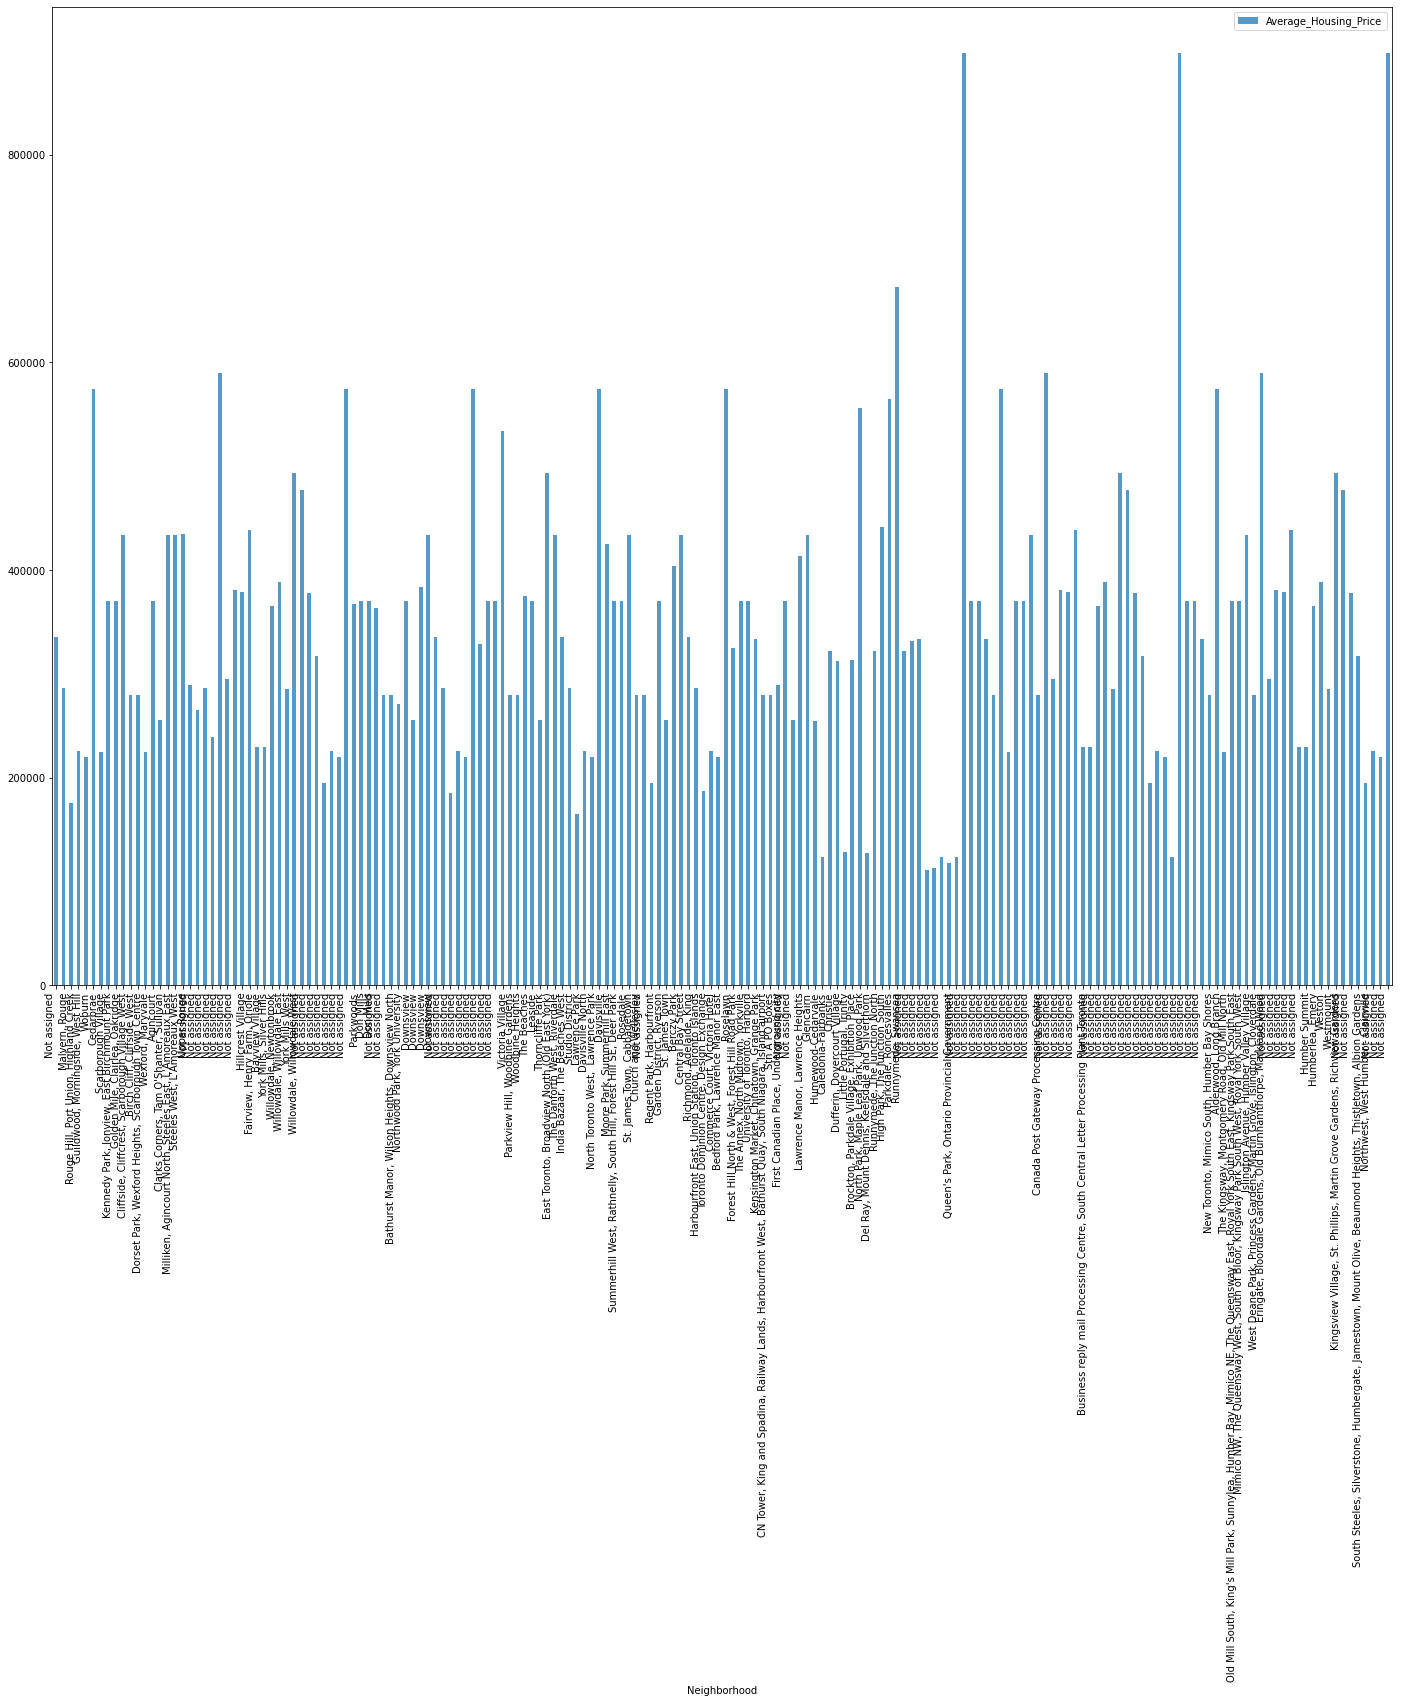

In [73]:
northyork_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## School Ratings

In [56]:

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [63]:
new_northyork=northyork_merged.set_index("Neighborhood",drop=True)

northyork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,8,8,7,7,7,7,6,6,5,3,2,1,4,2,3,4,5,9,4,2,1,1,1,2,3,4,5,6,7,1,9,1,6,9,9,9,
                                                           5,5,5,5,5,6,1,4,3,2,5,1,2,2,3,4,1,4,1,6,2,7,8,5,8,7,6,5,4,5,2,3,1,6,7,5,3,2,9,9,9
                                                           ]})


In [64]:
northyork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

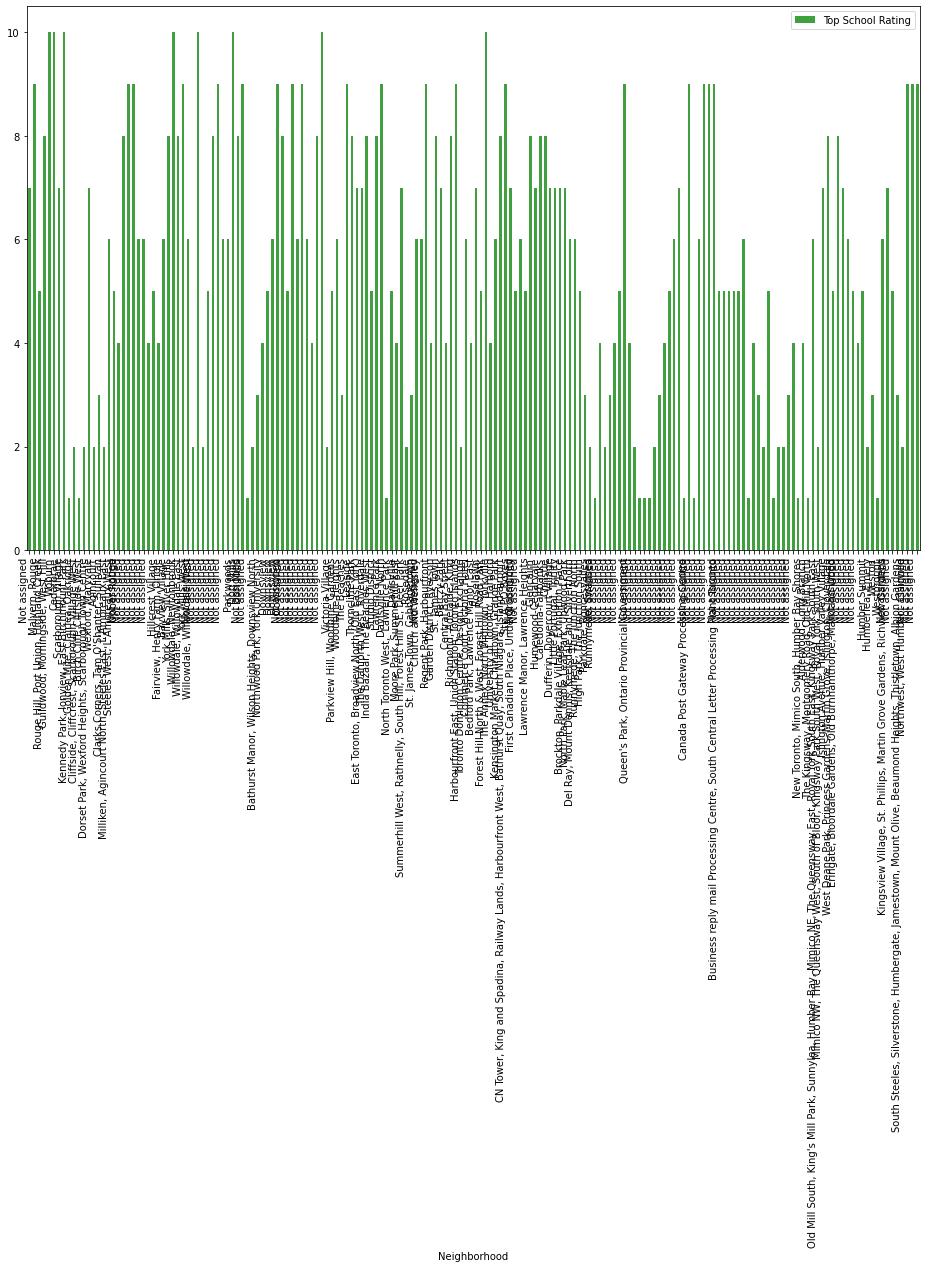

In [65]:
northyork_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

## Conclusion

    In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 180 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. 

    Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.